# Multiome Quickstart With Sparse Matrices

This notebook is mostly for demonstrating the utility of sparse matrices in this competition. (Especially for the Multiome dataset).

As the Multiome dataset is  very sparse (about 98% of cells are zeros), it benefits greatly from being encoded as sparse matrices. 

This notebook is largely based on [this notebook](https://www.kaggle.com/code/ambrosm/msci-multiome-quickstart) by AmbrosM. It is a nice first attempt at handling Multiome data, and I thought it would informative for kagglers to be able to contrast directly the performances of sparse vs dense representations. 

Mostly, the differences with AmbrosM's notebooks are:
- We use a representation of the data in sparse CSR format, which let us load all of the training data in memory (using less than 8GB memory instead of the >90GB it would take to represent the data in a dense format)
- We perform PCA (actually, TruncatedSVD) on the totality of the training data (while AmbrosM's notebook had to work with a subset of 6000 rows and 4000 columns). 
- We keep 16 components (vs 4 in AmbrosM's notebook)
- We apply Ridge regression on 50000 rows (vs 6000 in AmbrosM's notebook)
- Despite using much more data, this notebook should run in a bit more than 10 minutes (vs >1h for AmbrosM's notebook)

The competition data is pre-encoded as sparse matrices in [this dataset](https://www.kaggle.com/datasets/fabiencrom/multimodal-single-cell-as-sparse-matrix) generated by [this notebook](https://www.kaggle.com/code/fabiencrom/multimodal-single-cell-creating-sparse-data/).

Since we will only generate the multiome predictions in this notebook, I am taking the CITEseq predictions from [this notebook](https://www.kaggle.com/code/vuonglam/lgbm-baseline-optuna-drop-constant-cite-task) by VuongLam, which is the public notebook with the best score at the time I am publishing.


## CFG & import & scoring func

### CFG

In [ ]:
#CONFIG

CFG_seed = 42
CFG_n_folds = 5
CFG_target = 'target'
CFG_DEBUG = True
CFG_SUBMIT = True
CFG_RETRAIN = True
CFG_is_Colab = True

In [ ]:
import os

if CFG_is_Colab:
    FP_INPUT_DIR = '/content/drive/MyDrive/kaggle/Single-Cell Competition/data/input/'
    FP_OUTPUT_DIR = '/content/drive/MyDrive/kaggle/Single-Cell Competition/data/output/'
    
    from google.colab import drive
    drive.mount('/content/drive')
else:
    FP_INPUT_DIR = '../input/'
    FP_OUTPUT_DIR = './'


FP_INPUT_DIR = os.path.join(FP_INPUT_DIR, "multimodal-single-cell-as-sparse-matrix/")

FP_CELL_METADATA = os.path.join(FP_INPUT_DIR,"metadata.parquet")

FP_CITE_TRAIN_INPUTS_VALUES = os.path.join(FP_INPUT_DIR,"train_cite_inputs_values.sparse.npz")
FP_CITE_TRAIN_INPUTS_IDXCOL = os.path.join(FP_INPUT_DIR,"train_cite_inputs_idxcol.npz")
FP_CITE_TRAIN_TARGETS_VALUES = os.path.join(FP_INPUT_DIR,"train_cite_targets_values.sparse.npz")
FP_CITE_TRAIN_TARGETS_IDXCOL = os.path.join(FP_INPUT_DIR,"train_cite_targets_idxcol.npz")
FP_CITE_TEST_INPUTS_VALUES = os.path.join(FP_INPUT_DIR,"TEST_cite_inputs_values.sparse.npz")
FP_CITE_TEST_INPUTS_IDXCOL = os.path.join(FP_INPUT_DIR,"TEST_cite_inputs_idxcol.npz")

FP_MULTI_TRAIN_INPUTS_VALUES = os.path.join(FP_INPUT_DIR,"train_multi_inputs_values.sparse.npz")
FP_MULTI_TRAIN_INPUTS_IDXCOL = os.path.join(FP_INPUT_DIR,"train_multi_inputs_idxcol.npz")
FP_MULTI_TRAIN_TARGETS_VALUES = os.path.join(FP_INPUT_DIR,"train_multi_targets_values.sparse.npz")
FP_MULTI_TRAIN_TARGETS_IDXCOL = os.path.join(FP_INPUT_DIR,"train_multi_targets_idxcol.npz")
FP_MULTI_TEST_INPUTS_VALUES = os.path.join(FP_INPUT_DIR,"TEST_multi_inputs_values.sparse.npz")
FP_MULTI_TEST_INPUTS_IDXCOL = os.path.join(FP_INPUT_DIR,"TEST_multi_inputs_idxcol.npz")

FP_SUBMISSION = os.path.join(FP_INPUT_DIR,"sample_submission.parquet")
FP_EVALUATION = os.path.join(FP_INPUT_DIR,"evaluation.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import

In [ ]:
%pip install colorama
%pip install seaborn

import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os,gc,time,random
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

import scipy
import scipy.sparse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### The scoring function (from AmbrosM)

This competition has a special metric: For every row, it computes the Pearson correlation between y_true and y_pred, and then all these correlation coefficients are averaged.

In [ ]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)


# Preprocessing and cross-validation

We first load all of the training input data for Multiome. It should take less than a minute.

In [ ]:
%%time
train_inputs = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)

CPU times: user 37.5 s, sys: 3.44 s, total: 41 s
Wall time: 53.6 s


In [ ]:
meta = pd.read_parquet(FP_CELL_METADATA)
meta = meta[meta.technology == 'multiome']
meta.drop('technology', axis=1)
display(meta)
display(len(meta['cell_id'].unique()))

NameError: name 'pd' is not defined

## PCA / TruncatedSVD
It is not possible to directly apply PCA to a sparse matrix, because PCA has to first "center" the data, which destroys the sparsity. This is why we apply `TruncatedSVD` instead (which is pretty much "PCA without centering"). It might be better to normalize the data a bit more here, but we will keep it simple.

In [ ]:
%%time

# read data
train_inputs = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)

train_inputs = scipy.sparse.csc_matrix(train_inputs)
train_inputs

CPU times: user 1min 4s, sys: 2.17 s, total: 1min 6s
Wall time: 1min 6s


<105942x228942 sparse matrix of type '<class 'numpy.float32'>'
	with 607301546 stored elements in Compressed Sparse Column format>

In [ ]:
small_m = train_inputs[0:1001,0:1001]

print(small_m)

  (24, 0)	3.7773771
  (90, 0)	2.5922337
  (152, 0)	4.5441823
  (250, 0)	3.8404546
  (369, 0)	3.7110975
  (631, 0)	2.0328188
  (636, 0)	6.5053067
  (673, 0)	3.716107
  (815, 0)	4.0937476
  (937, 0)	3.0356164
  (162, 1)	2.215227
  (163, 1)	4.1733246
  (225, 1)	2.8392403
  (251, 1)	2.18405
  (357, 1)	4.3101377
  (401, 1)	5.3339424
  (660, 1)	5.2887654
  (753, 1)	4.6152463
  (815, 1)	2.743474
  (868, 1)	6.476964
  (22, 2)	4.2520895
  (449, 2)	4.412009
  (514, 2)	4.0301256
  (630, 2)	5.3164864
  (961, 2)	5.523783
  :	:
  (138, 999)	3.9724474
  (188, 999)	1.3088036
  (244, 999)	2.786133
  (458, 999)	3.4857843
  (491, 999)	2.2765872
  (503, 999)	2.490928
  (615, 999)	3.3429527
  (619, 999)	2.4601016
  (719, 999)	3.2471945
  (723, 999)	2.9858527
  (887, 999)	1.997561
  (899, 999)	3.64769
  (913, 999)	3.97529
  (973, 999)	2.8668149
  (14, 1000)	3.3109694
  (36, 1000)	3.7703648
  (230, 1000)	3.9203007
  (256, 1000)	3.7664287
  (623, 1000)	3.6429272
  (683, 1000)	3.5954762
  (719, 1000)	4.0281215

IndexError: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler

train = train_inputs[:500]
scalar = StandardScaler(with_mean=False)
train_scaled = scalar.fit_transform(train)

In [ ]:
train_scaled_sq = train_scaled.multiply(train_scaled)
print(train.max())
print(f'mean: {train.mean()}')
print(f'min: {train.min()}')
print(f'max: {train.max()}')
print(f'mean: {train_scaled.mean()}')
print(f'min: {train_scaled.min()}')
print(f'max: {train_scaled.max()}')

for i in range(5):
    m = train_scaled.getcol(i).mean()
    print(train_scaled_sq.getcol(i).mean() - m*m) # variance


15.590632
mean: 0.05371995270252228
min: 0.0
max: 15.590632438659668
mean: 0.11175207048654556
min: 0.0
max: 22.383073806762695
0.99999994
0.99999994
1.0
1.0
0.9999999


In [ ]:
print(repr(train_inputs.A))

In [ ]:
for i in range(0,5):
    print(f'mean: {train_inputs.getcol(i).mean()}')
    print(f'min: {train_inputs.getcol(i).min()}')
    print(f'max: {train_inputs.getcol(i).max()}')
scalar.transform(train_inputs)
for i in range(0,5):
    print(f'mean: {train_inputs.getcol(i).mean()}')
    print(f'min: {train_inputs.getcol(i).min()}')
    print(f'max: {train_inputs.getcol(i).max()}')

mean: 0.03302547335624695
min: 0.0
max: 10.165501594543457
mean: 0.032783880829811096
min: 0.0
max: 11.767000198364258
mean: 0.007037467323243618
min: 0.0
max: 9.63918685913086
mean: 0.011736416257917881
min: 0.0
max: 13.753134727478027
mean: 0.02440371923148632
min: 0.0
max: 12.015839576721191
mean: 0.03302547335624695
min: 0.0
max: 10.165501594543457
mean: 0.032783880829811096
min: 0.0
max: 11.767000198364258
mean: 0.007037467323243618
min: 0.0
max: 9.63918685913086
mean: 0.011736416257917881
min: 0.0
max: 13.753134727478027
mean: 0.02440371923148632
min: 0.0
max: 12.015839576721191


In [ ]:
print(train_inputs.nnz)
print(train_inputs.shape)
num_of_elements = train_inputs.shape[0]*train_inputs.shape[1]
print(f'sparsity: {train_inputs.nnz/num_of_elements*100:f}%')
print(f'mean: {train_inputs.mean().mean()}')
print(f'min: {train_inputs.min().min()}')
print(f'max: {train_inputs.max().max()}')

607301546
(105942, 228942)
sparsity: 2.503864%
mean: 0.049846068024635315
min: 0.0
max: 18.601043701171875


sum:  0.010998284


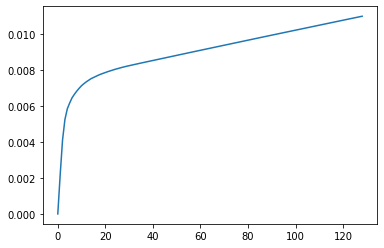

CPU times: user 22min 4s, sys: 15.9 s, total: 22min 20s
Wall time: 21min 56s


In [ ]:
%%time


# dimension reduction
pca128 = TruncatedSVD(n_components=128, random_state=1)
pca128.fit_transform(train_inputs)

# analytics
print('sum: ',pca128.explained_variance_ratio_.sum())
ev_ratio = pca128.explained_variance_ratio_
ev_ratio = np.hstack([0,ev_ratio.cumsum()])
plt.plot(ev_ratio)
plt.show()

In [ ]:
import pickle

with open(FP_OUTPUT_DIR+'pca128.pickle', mode='wb') as fp:
    pickle.dump(pca128, fp)

In [ ]:
# train_inputs = pd.DataFrame(train_inputs)
display(train_inputs)
print(f'shape: {train_inputs.shape}')
train_inputs.to_csv(FP_OUTPUT_DIR + 'train_multi_inputs_svd_16.csv', index_label='idx')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,38.509930,-10.375854,7.537704,8.037355,-0.732825,-2.628380,-0.288972,-2.307305,0.927529,-0.056414,-1.895019,-3.891564,-0.425351,-1.002920,-0.340402,-0.119058
1,30.817234,-1.838607,-4.246789,-1.954858,1.377517,4.511815,-1.024801,-0.530675,-0.163089,2.869058,-1.537686,-2.362415,-1.199675,-1.153779,0.904145,-1.240860
2,36.987301,-3.492022,6.085456,1.428516,-3.303646,-4.903047,-1.270028,-1.176299,1.169367,0.794723,-0.907491,0.307577,2.002752,3.121383,0.670210,-0.093615
3,37.912418,-6.596242,-3.248398,0.754830,-1.327523,-1.972466,2.484417,-0.833040,1.729253,0.198159,-3.240337,-0.350120,0.562632,-0.015158,-0.620967,-0.831005
4,36.362854,3.175058,-3.435925,-3.267490,-0.867052,-5.337866,-2.026093,-0.573063,0.904733,1.435328,1.819998,1.107228,2.161990,1.167548,-3.016197,-0.011329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105937,39.596977,-3.623633,-10.243509,-5.893878,-0.231879,-0.703768,-0.922572,-2.425726,1.840160,0.765674,3.240195,-3.343739,1.267614,0.197710,-1.723898,-1.290524
105938,42.908493,2.417342,19.556194,-10.470856,1.650638,5.901397,-0.144920,-1.375678,2.251510,-0.551154,0.781630,1.125385,-1.238701,0.242214,-1.488485,-2.612272
105939,44.719109,-9.063395,3.261071,4.544597,0.662093,3.645386,-3.245217,1.319367,-2.402423,1.494154,-1.767643,1.248267,-1.833109,1.712172,-1.581642,1.635358
105940,35.997238,15.258488,-0.600117,5.331388,-3.661520,3.657462,2.049189,-1.527557,1.817238,1.912080,-1.512946,-0.682216,0.578346,0.594552,-0.151050,0.498110


In [ ]:
train_inputs = np.array(train_inputs)

In [ ]:
train = pd.read_csv(FP_OUTPUT_DIR + 'train_multi_inputs_svd_16.csv', index_col='idx')
# train.drop('Unnamed: 0',axis=1, inplace=True)
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
idx,,,,,,,,,,,,,,,,
0,38.509930,-10.375855,7.537705,8.037355,-0.732825,-2.628380,-0.288972,-2.307305,0.927529,-0.056414,-1.895019,-3.891564,-0.425351,-1.002920,-0.340402,-0.119058
1,30.817234,-1.838607,-4.246790,-1.954858,1.377517,4.511815,-1.024801,-0.530675,-0.163089,2.869058,-1.537686,-2.362415,-1.199675,-1.153779,0.904145,-1.240860
2,36.987300,-3.492022,6.085456,1.428516,-3.303646,-4.903047,-1.270028,-1.176299,1.169367,0.794723,-0.907491,0.307577,2.002752,3.121383,0.670210,-0.093615
3,37.912420,-6.596242,-3.248398,0.754830,-1.327523,-1.972466,2.484417,-0.833040,1.729253,0.198159,-3.240337,-0.350119,0.562632,-0.015158,-0.620967,-0.831005
4,36.362854,3.175058,-3.435925,-3.267490,-0.867053,-5.337866,-2.026093,-0.573063,0.904733,1.435328,1.819998,1.107228,2.161990,1.167548,-3.016197,-0.011329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105937,39.596977,-3.623633,-10.243509,-5.893878,-0.231879,-0.703769,-0.922572,-2.425726,1.840159,0.765674,3.240195,-3.343739,1.267614,0.197710,-1.723898,-1.290524
105938,42.908493,2.417342,19.556194,-10.470856,1.650638,5.901397,-0.144920,-1.375678,2.251510,-0.551154,0.781630,1.125385,-1.238701,0.242214,-1.488485,-2.612272
105939,44.719110,-9.063395,3.261071,4.544597,0.662093,3.645386,-3.245217,1.319367,-2.402423,1.494154,-1.767643,1.248267,-1.833109,1.712172,-1.581642,1.635358


## Random row selection and conversion of the target data to a dense matrix

Unfortunately, although sklearn's `Ridge` regressor do accept sparse matrices as input, it does not accept sparse matrices as target values. This means we will have to convert the targets to a dense format. Although we could fit in memory both the dense target data and the sparse input data, the Ridge regression process would then lack memory. Therefore, from now on, we will work with a subset of 50 000 rows from the training data.

In [ ]:
np.random.seed(42)
all_row_indices = np.arange(train_inputs.shape[0])
np.random.shuffle(all_row_indices)
if CFG_DEBUG:        
    selected_rows_indices = all_row_indices[:1000]
else:
    selected_rows_indices = all_row_indices[:]

In [ ]:
train_inputs = train_inputs[selected_rows_indices]
gc.collect()

203

In [ ]:
%%time
train_target = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)

CPU times: user 42.6 s, sys: 4.26 s, total: 46.9 s
Wall time: 49.7 s


In [ ]:
%%time
train_target = train_target[selected_rows_indices]
train_target = train_target.todense()
gc.collect()

CPU times: user 254 ms, sys: 1.12 s, total: 1.38 s
Wall time: 1.32 s


106

## KFold Ridge regression
`sklearn` complains that we should use array instead of matrices. Unfortunately, the old `scipy` version available on kaggle do not provide sparse arrays; only sparse matrices. So we suppress the warnings.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

This Kfold ridge regression code is mostly taken from AmbrosM's [notebook](https://www.kaggle.com/code/ambrosm/msci-multiome-quickstart). Note that `sklearn`'s `Ridge` handles sparse matrices transparently. I found [this blog post](https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/) that list the other algorithms of `sklearn` that accept sparse matrices.

In [ ]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_inputs)):
    model = None
    gc.collect()
    X_tr = train_inputs[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = train_target[idx_tr]
    print(f'y_tr: {y_tr}\n')
    print(f'y_tr shape: {y_tr.shape}\n')
    del idx_tr

    model = Ridge(copy_X=False)
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = train_inputs[idx_va]
    y_va = train_target[idx_va]
    del idx_va
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

    if CFG_DEBUG: break

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}{train_inputs.shape} Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")


y_tr: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y_tr shape: (800, 228942)

Fold 0: mse = 0.15041, corr =  0.114
(1000, 16) Average  mse = 0.15041; corr = 0.114
CPU times: user 2.68 s, sys: 760 ms, total: 3.44 s
Wall time: 1.99 s


# Retraining


In [ ]:
# We retrain the model and then delete the training data, which is no longer needed

if CFG_SUBMIT:
    model, score_list, result_df = None, None, None # free the RAM occupied by the old model
    gc.collect()
    model = Ridge(copy_X=False) # we overwrite the training data
    model.fit(train_inputs, train_target)
    del train_inputs, train_target # free the RAM
    gc.collect()

# Predicting

In [ ]:
%%time
if CFG_SUBMIT:
    multi_test_x = scipy.sparse.load_npz(FP_INPUT_DIR + "multimodal-single-cell-as-sparse-matrix/test_multi_inputs_values.sparse.npz")
    multi_test_x = pca.transform(multi_test_x)
    test_pred = model.predict(multi_test_x)
    del multi_test_x
    gc.collect()

CPU times: user 29.1 s, sys: 10.2 s, total: 39.3 s
Wall time: 38.7 s


62

# Creating submission

We load the cells that will have to appear in submission.

In [ ]:
%%time



# Read the table of rows and columns required for submission
eval_ids = pd.read_parquet(FP_INPUT_DIR + 'multimodal-single-cell-as-sparse-matrix/evaluation.parquet')

# Convert the string columns to more efficient categorical types
#eval_ids.cell_id = eval_ids.cell_id.apply(lambda s: int(s, base=16))

eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())


CPU times: user 22.2 s, sys: 3.78 s, total: 26 s
Wall time: 26.7 s


In [ ]:
display(eval_ids)
display(eval_ids['cell_id'].unique())
display(eval_ids['gene_id'].unique())

,row_id,cell_id,gene_id
0,0,c2150f55becb,CD86
1,1,c2150f55becb,CD274
2,2,c2150f55becb,CD270
3,3,c2150f55becb,CD155
4,4,c2150f55becb,CD112
...,...,...,...
65744175,65744175,2c53aa67933d,ENSG00000134419
65744176,65744176,2c53aa67933d,ENSG00000186862
65744177,65744177,2c53aa67933d,ENSG00000170959
65744178,65744178,2c53aa67933d,ENSG00000107874


['c2150f55becb', '65b7edf8a4da', 'c1b26cb1057b', '917168fa6f83', '2b29feeca86d', ..., 'c74771e1f87f', 'e6d085b09d0b', '0ddfc0ba4098', '31b078475100', '2c53aa67933d']
Length: 65443
Categories (65443, object): ['00038e5227c6', '000398b2716c', '0004eac50a63', '00074a4b8e79', ...,
                             'fffb5bf0f2c1', 'fffc4f7b926e', 'fffdb2c9bd1e', 'fffe4c1f0053']

['CD86', 'CD274', 'CD270', 'CD155', 'CD112', ..., 'ENSG00000230479', 'ENSG00000144130', 'ENSG00000188800', 'ENSG00000114650', 'ENSG00000125686']
Length: 23558
Categories (23558, object): ['CD101', 'CD103', 'CD105', 'CD107a', ..., 'TCRVa7.2', 'TCRVd2', 'TIGIT',
                             'integrinB7']

In [ ]:
# Prepare an empty series which will be filled with predictions
submission = pd.Series(name='target',
                       index=pd.MultiIndex.from_frame(eval_ids), 
                       dtype=np.float32)

submission

row_id    cell_id       gene_id        
0         c2150f55becb  CD86              NaN
1         c2150f55becb  CD274             NaN
2         c2150f55becb  CD270             NaN
3         c2150f55becb  CD155             NaN
4         c2150f55becb  CD112             NaN
                                           ..
65744175  2c53aa67933d  ENSG00000134419   NaN
65744176  2c53aa67933d  ENSG00000186862   NaN
65744177  2c53aa67933d  ENSG00000170959   NaN
65744178  2c53aa67933d  ENSG00000107874   NaN
65744179  2c53aa67933d  ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

We load the `index`  and `columns` of the original dataframe, as we need them to make the submission.

In [ ]:
%%time
y_columns = np.load(FP_INPUT_DIR + "multimodal-single-cell-as-sparse-matrix/train_multi_targets_idxcol.npz",
                   allow_pickle=True)["columns"]

test_index = np.load(FP_INPUT_DIR + "multimodal-single-cell-as-sparse-matrix/test_multi_inputs_idxcol.npz",
                    allow_pickle=True)["index"]
train_index = np.load(FP_INPUT_DIR + "multimodal-single-cell-as-sparse-matrix/train_multi_inputs_idxcol.npz",
                    allow_pickle=True)["index"]

print(f'y_columns: {y_columns}\n')
print(f'test_index: {test_index}\n')
print(f'test_index: {len(test_index)}\n')
print(f'train_index: {train_index}\n')
print(f'train_index: {len(train_index)}\n')

y_columns: ['ENSG00000121410' 'ENSG00000268895' 'ENSG00000175899' ...
 'ENSG00000162378' 'ENSG00000159840' 'ENSG00000074755']

test_index: ['458c2ae2c9b1' '01a0659b0710' '028a8bc3f2ba' ... '05666c99aa48'
 '121f946642b5' 'b847ba21f59f']

test_index: 55935

train_index: ['56390cf1b95e' 'fc0c60183c33' '9b4a87e22ad0' ... '00783f28b463'
 'e7abb1a0f251' '193992d571a5']

train_index: 105942

CPU times: user 80 ms, sys: 13.2 ms, total: 93.3 ms
Wall time: 1.13 s


We assign the predicted values to the correct row in the submission file.

In [ ]:
cell_dict = dict((k,v) for v,k in enumerate(test_index))
assert len(cell_dict)  == len(test_index)

gene_dict = dict((k,v) for v,k in enumerate(y_columns))
assert len(gene_dict) == len(y_columns)

print(f'cell_dict length: {len(cell_dict)}\n')
print(f'cell_dict: {cell_dict}\n')

print(f'gene_dict length: {len(gene_dict)}\n')
print(f'gene_dict: {gene_dict}\n')

cell_dict length: 55935

cell_dict: {'458c2ae2c9b1': 0, '01a0659b0710': 1, '028a8bc3f2ba': 2, '7ec0ca8bb863': 3, 'caa0b0022cdc': 4, 'e0bc46450106': 5, '632ae0df4dcd': 6, '852044b3a2c9': 7, 'fc09f456158f': 8, '6e3df813cfcf': 9, 'a36b5f65a2b4': 10, '20c56de1cec7': 11, 'f761aff20d94': 12, '651d314a28d1': 13, '0f5a5fbbd3cf': 14, 'd1fe809e3ec6': 15, 'feb7195fef08': 16, 'b290587650b9': 17, '4ad5ef1d14ed': 18, '81bdc45c1480': 19, '7eeb7e926f71': 20, 'e8652be37372': 21, 'f16910c43d66': 22, '5ca7a64be856': 23, 'b76dd042700b': 24, '003c666032d2': 25, '0e56e6a1ed1c': 26, 'b74b0ade1805': 27, '66938df17257': 28, 'fffd9e9e61d7': 29, 'e71c3f54d232': 30, '9ecb9b0920ca': 31, '61fec1c2a4f0': 32, 'c1082045870f': 33, '725c7b3b6045': 34, '0fd2a85efe40': 35, 'f6a90f4dcf1c': 36, 'a0e89e0afc1f': 37, 'd8b0515f33db': 38, '7857baaf8483': 39, '45e49e610389': 40, '51e70ce6e71e': 41, '8d7359331793': 42, '774841aa538f': 43, '14ed1acc48a7': 44, 'b1eb3070dbf9': 45, '05a9e5814c99': 46, '74c08c24a759': 47, '1d7c6c370bec

In [ ]:
print(eval_ids.cell_id)
print(cell_dict.get('c2150f55becb'))
print(cell_dict.get('2c53aa67933d'))

0           c2150f55becb
1           c2150f55becb
2           c2150f55becb
3           c2150f55becb
4           c2150f55becb
                ...     
65744175    2c53aa67933d
65744176    2c53aa67933d
65744177    2c53aa67933d
65744178    2c53aa67933d
65744179    2c53aa67933d
Name: cell_id, Length: 65744180, dtype: category
Categories (65443, object): ['00038e5227c6', '000398b2716c', '0004eac50a63', '00074a4b8e79', ...,
                             'fffb5bf0f2c1', 'fffc4f7b926e', 'fffdb2c9bd1e', 'fffe4c1f0053']
None
22360


In [ ]:
# dict.get(key, value)で、dictがkeyを持たない場合、valueを返すよう設定できる
# この場合では、-1を返す
eval_ids_cell_num = eval_ids.cell_id.apply(lambda x:cell_dict.get(x, -1))
eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))

valid_multi_rows = (eval_ids_gene_num !=-1) & (eval_ids_cell_num!=-1)
rows1 =  (eval_ids_gene_num !=-1)
rows2 =  (eval_ids_cell_num !=-1)

print(f'eval_ids_cell_num: \n{eval_ids_cell_num}\n')
print(f'eval_ids_gene_num: \n{eval_ids_gene_num}\n')
print(f'valid_multi_rows: \n{valid_multi_rows}\n')
print(f'valid_multi_rows sum: \n{valid_multi_rows.sum()}\n')
print(f'rows1 sum: \n{rows1.sum()}\n')
print(f'rows2 sum: \n{rows2.sum()}\n')

eval_ids_cell_num: 
0              -1
1              -1
2              -1
3              -1
4              -1
            ...  
65744175    22360
65744176    22360
65744177    22360
65744178    22360
65744179    22360
Name: cell_id, Length: 65744180, dtype: int64

eval_ids_gene_num: 
0              -1
1              -1
2              -1
3              -1
4              -1
            ...  
65744175    18559
65744176    16661
65744177     9200
65744178     9012
65744179    20487
Name: gene_id, Length: 65744180, dtype: int64

valid_multi_rows: 
0           False
1           False
2           False
3           False
4           False
            ...  
65744175     True
65744176     True
65744177     True
65744178     True
65744179     True
Length: 65744180, dtype: bool

valid_multi_rows sum: 
58931360

rows1 sum: 
58931360

rows2 sum: 
58931360



In [ ]:
submission.iloc[valid_multi_rows] = test_pred[eval_ids_cell_num[valid_multi_rows].to_numpy(),
eval_ids_gene_num[valid_multi_rows].to_numpy()]

In [ ]:
del eval_ids_cell_num, eval_ids_gene_num, valid_multi_rows, eval_ids, test_index, y_columns
gc.collect()

57

In [ ]:
submission

row_id    cell_id       gene_id        
0         c2150f55becb  CD86                    NaN
1         c2150f55becb  CD274                   NaN
2         c2150f55becb  CD270                   NaN
3         c2150f55becb  CD155                   NaN
4         c2150f55becb  CD112                   NaN
                                             ...   
65744175  2c53aa67933d  ENSG00000134419    6.701083
65744176  2c53aa67933d  ENSG00000186862    0.015456
65744177  2c53aa67933d  ENSG00000170959    0.023022
65744178  2c53aa67933d  ENSG00000107874    1.361718
65744179  2c53aa67933d  ENSG00000166012    5.148006
Name: target, Length: 65744180, dtype: float32

# Merging with CITEseq predictions

We use the CITEseq predictions from [this notebook](https://www.kaggle.com/code/vuonglam/lgbm-baseline-optuna-drop-constant-cite-task) by VuongLam.

In [ ]:
submission.reset_index(drop=True, inplace=True)
submission.index.name = 'row_id'
# with open("partial_submission_multi.pickle", 'wb') as f:
#     pickle.dump(submission, f)
# submission

In [ ]:
cite_submission = pd.read_csv(FP_INPUT_DIR + "lgbm-baseline-optuna-drop-constant-cite-task/submission.csv")
cite_submission = cite_submission.set_index("row_id")
cite_submission = cite_submission["target"]

In [ ]:
submission[submission.isnull()] = cite_submission[submission.isnull()]

In [ ]:
submission

row_id
0           0.803339
1           0.581506
2           0.080100
3           2.006412
4           3.857997
              ...   
65744175    6.701083
65744176    0.015456
65744177    0.023022
65744178    1.361718
65744179    5.148006
Name: target, Length: 65744180, dtype: float32

In [ ]:
submission.isnull().any()

False

In [ ]:
submission.to_csv(FP_OUTPUT_DIR + "submission.csv")

In [ ]:
!head submission.csv

head: cannot open 'submission.csv' for reading: No such file or directory
